# Week 5 Image Feature Extraction — China

This notebook extracts country–year features from annual GeoTIFFs (VIIRS nightlights + population) using a tile-based pipeline designed to handle very large rasters without freezing.


In [1]:
import os, glob, re, math
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# === USER PATH ===
DATA_PATH = r"C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images"
COUNTRY = "China"
YEARS = list(range(2014, 2024))

# Outputs
OUTPUT_DIR = os.path.join(DATA_PATH, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# GeoTIFF discovery (search in country subfolder first; fall back to root)
def list_country_tifs(country):
    patterns = [
        os.path.join(DATA_PATH, country, f"{country}_*.tif"),
        os.path.join(DATA_PATH, f"{country}_*.tif"),
    ]
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    return sorted(set(files))

tifs = list_country_tifs(COUNTRY)
years_found = sorted([int(re.findall(r"_(\d{4})", os.path.basename(f))[0]) for f in tifs]) if tifs else []
print("Country:", COUNTRY)
print("TIFs found:", len(tifs))
print("Years found:", years_found)
if tifs:
    print("Example file:", os.path.basename(tifs[0]))


Country: China
TIFs found: 10
Years found: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Example file: China_2014.tif


## Helpers: safe window reading + adaptive tiling

In [2]:
def _read_band_window(ds, band_index, window):
    """Read a band for a rasterio dataset in a window as float32 with nodata -> NaN."""
    a = ds.read(band_index, window=window, masked=True).astype("float32")
    if hasattr(a, "filled"):
        a = a.filled(np.nan)
    return a

def choose_tile_size(height, width, target_tiles=4000, min_size=128, max_size=1024):
    """Pick a tile size so the grid has ~target_tiles tiles (bounded)."""
    total_px = float(height) * float(width)
    tile_px = max(1.0, total_px / float(target_tiles))
    size = int(round(math.sqrt(tile_px)))
    size = max(min_size, min(max_size, size))
    return max(1, size)

def windows_for_shape(height, width, tile_size):
    """Yield rasterio windows covering the raster."""
    from rasterio.windows import Window
    for r0 in range(0, height, tile_size):
        for c0 in range(0, width, tile_size):
            h = min(tile_size, height - r0)
            w = min(tile_size, width - c0)
            yield (r0, c0), Window(c0, r0, w, h)

def gini_from_hist(counts, bin_edges):
    """Approximate Gini from histogram (counts over bins with edges)."""
    counts = np.asarray(counts, dtype=np.float64)
    if counts.sum() <= 0:
        return np.nan
    mids = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    order = np.argsort(mids)
    x = mids[order]
    w = counts[order]
    W = w.sum()
    mu = (w * x).sum() / W
    if mu == 0:
        return 0.0
    cw = np.cumsum(w) / W
    cwx = np.cumsum(w * x) / (W * mu)
    B = np.trapz(cwx, cw)
    return float(1.0 - 2.0 * B)

def hist_quantile(counts, bin_edges, q):
    """Approximate quantile from histogram."""
    counts = np.asarray(counts, dtype=np.float64)
    if counts.sum() <= 0:
        return np.nan
    cum = np.cumsum(counts)
    target = q * cum[-1]
    idx = int(np.searchsorted(cum, target, side="left"))
    idx = max(0, min(idx, len(bin_edges) - 2))
    return float(bin_edges[idx+1])

def safe_corr(x, y):
    """Correlation with guards to avoid warnings (needs >=3 and std>0)."""
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    if x.size < 3:
        return np.nan
    sx = np.std(x); sy = np.std(y)
    if sx == 0 or sy == 0:
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])


## Core feature extraction (tile-based, two-pass)

In [3]:
def tif_path(country, year):
    fp1 = os.path.join(DATA_PATH, country, f"{country}_{year}.tif")
    fp2 = os.path.join(DATA_PATH, f"{country}_{year}.tif")
    if os.path.exists(fp1):
        return fp1
    if os.path.exists(fp2):
        return fp2
    return None

def extract_features_for_year(country, year, scatter_sample_max=40000, pop_q_sample_max=250000):
    fp = tif_path(country, year)
    if fp is None:
        return None

    with rasterio.open(fp) as ds:
        H, W = ds.height, ds.width
        tile_size = choose_tile_size(H, W, target_tiles=4000, min_size=128, max_size=1024)
        grid_h = int(math.ceil(H / tile_size))
        grid_w = int(math.ceil(W / tile_size))

        # PASS 1: global aggregates + samples + NL histogram in log1p space
        nl_log_bins = np.linspace(0.0, 10.0, 1001)
        nl_log_counts = np.zeros(len(nl_log_bins) - 1, dtype=np.int64)

        area_pixels = 0
        nl_sum = 0.0
        nl_sumsq = 0.0
        pop_sum = 0.0

        pop_log_sample_parts = []
        scatter_pop_log_parts = []
        scatter_nl_log_parts = []

        rng = np.random.default_rng(42 + year)

        for (r0c0, win) in windows_for_shape(H, W, tile_size):
            nl = _read_band_window(ds, 1, win)
            pop = _read_band_window(ds, 2, win)

            m = np.isfinite(nl) & np.isfinite(pop)
            if not np.any(m):
                continue

            nl_v = nl[m]
            pop_v = pop[m]

            area_pixels += int(nl_v.size)
            nl_sum += float(np.nansum(nl_v))
            nl_sumsq += float(np.nansum(nl_v * nl_v))
            pop_sum += float(np.nansum(pop_v))

            nl_pos = nl_v[nl_v > 0]
            if nl_pos.size:
                nl_log = np.log1p(nl_pos)
                nl_log_counts += np.histogram(nl_log, bins=nl_log_bins)[0]

            # pop quantile sample (log1p)
            pop_pos = pop_v[pop_v > 0]
            if pop_pos.size:
                pop_log = np.log1p(pop_pos)
                take = min(2000, pop_log.size)
                idx = rng.choice(pop_log.size, size=take, replace=False) if pop_log.size > take else np.arange(pop_log.size)
                pop_log_sample_parts.append(pop_log[idx])

            # scatter sample pieces
            take = min(1500, nl_v.size)
            idx = rng.choice(nl_v.size, size=take, replace=False) if nl_v.size > take else np.arange(nl_v.size)
            scatter_pop_log_parts.append(np.log1p(np.maximum(pop_v[idx], 0)))
            scatter_nl_log_parts.append(np.log1p(np.maximum(nl_v[idx], 0)))

        if area_pixels == 0:
            return None

        pop_log_sample = np.concatenate(pop_log_sample_parts) if pop_log_sample_parts else np.array([], dtype=np.float32)
        if pop_log_sample.size > pop_q_sample_max:
            idx = rng.choice(pop_log_sample.size, size=pop_q_sample_max, replace=False)
            pop_log_sample = pop_log_sample[idx]

        scatter_pop_log = np.concatenate(scatter_pop_log_parts) if scatter_pop_log_parts else np.array([], dtype=np.float32)
        scatter_nl_log = np.concatenate(scatter_nl_log_parts) if scatter_nl_log_parts else np.array([], dtype=np.float32)
        if scatter_pop_log.size > scatter_sample_max:
            idx = rng.choice(scatter_pop_log.size, size=scatter_sample_max, replace=False)
            scatter_pop_log = scatter_pop_log[idx]
            scatter_nl_log = scatter_nl_log[idx]

        mean_light = nl_sum / area_pixels
        var_light = max(0.0, nl_sumsq / area_pixels - mean_light * mean_light)
        std_light = math.sqrt(var_light)

        nl_log_p90 = hist_quantile(nl_log_counts, nl_log_bins, 0.90)
        lit_threshold_p90 = float(np.expm1(nl_log_p90)) if np.isfinite(nl_log_p90) else np.nan

        nl_bins = np.expm1(nl_log_bins)
        gini_light_pos = gini_from_hist(nl_log_counts, nl_bins)

        if pop_log_sample.size >= 10:
            q = np.quantile(pop_log_sample, [0.2, 0.4, 0.6, 0.8])
        else:
            q = np.array([0.5, 1.0, 2.0, 3.0], dtype=float)

        # PASS 2: tail + pop-bin shares + tile summaries
        lit_px = 0
        lit_light_mass = 0.0

        bin_light = np.zeros(5, dtype=np.float64)
        total_light_mass_pos = 0.0

        tile_rows = []
        tile_pop_mean = np.full((grid_h, grid_w), np.nan, dtype=np.float32)
        tile_nl_mean = np.full((grid_h, grid_w), np.nan, dtype=np.float32)
        tile_corr = np.full((grid_h, grid_w), np.nan, dtype=np.float32)

        for (r0c0, win) in windows_for_shape(H, W, tile_size):
            (r0, c0) = r0c0
            gi = r0 // tile_size
            gj = c0 // tile_size

            nl = _read_band_window(ds, 1, win)
            pop = _read_band_window(ds, 2, win)
            m = np.isfinite(nl) & np.isfinite(pop)
            if not np.any(m):
                continue
            nl_v = nl[m]
            pop_v = pop[m]

            nl_use = np.maximum(nl_v, 0)
            pop_use = np.maximum(pop_v, 0)

            # Positive-only total light mass for stability
            total_light_mass_pos += float(np.sum(nl_use))

            # Tail (p90)
            if np.isfinite(lit_threshold_p90):
                tail = nl_v >= lit_threshold_p90
                if np.any(tail):
                    lit_px += int(np.sum(tail))
                    lit_light_mass += float(np.sum(nl_use[tail]))

            # Pop bins by log1p(pop)
            pop_log = np.log1p(pop_use)
            b = np.digitize(pop_log, q, right=True)  # 0..4
            for k in range(5):
                mk = (b == k)
                if np.any(mk):
                    bin_light[k] += float(np.sum(nl_use[mk]))

            # Tile summaries
            nl_mean = float(np.mean(nl_use))
            pop_mean = float(np.mean(pop_use))
            tile_nl_mean[gi, gj] = nl_mean
            tile_pop_mean[gi, gj] = pop_mean

            take = min(5000, nl_v.size)
            idx = rng.choice(nl_v.size, size=take, replace=False) if nl_v.size > take else np.arange(nl_v.size)
            corr = safe_corr(pop_use[idx], nl_use[idx])
            tile_corr[gi, gj] = corr

            tile_rows.append({
                "tile_i": int(gi), "tile_j": int(gj),
                "tile_pop_mean": pop_mean,
                "tile_nl_mean": nl_mean,
                "tile_corr": float(corr) if np.isfinite(corr) else np.nan,
                "tile_px": int(nl_v.size),
            })

        lit_fraction_p90 = (lit_px / area_pixels) if area_pixels else np.nan
        light_mass_lit_p90 = (lit_light_mass / total_light_mass_pos) if total_light_mass_pos > 0 else np.nan

        bin_share = (bin_light / bin_light.sum()) if bin_light.sum() > 0 else np.full(5, np.nan)

        pop_vals = tile_pop_mean[np.isfinite(tile_pop_mean)]
        nl_vals = tile_nl_mean[np.isfinite(tile_nl_mean)]
        pop_q25, pop_q50, pop_q75 = (np.quantile(pop_vals, [0.25, 0.50, 0.75]) if pop_vals.size >= 10 else (np.nan, np.nan, np.nan))
        nl_q25, nl_q50, nl_q75 = (np.quantile(nl_vals, [0.25, 0.50, 0.75]) if nl_vals.size >= 10 else (np.nan, np.nan, np.nan))

        region_grid = np.zeros((grid_h, grid_w), dtype=np.int8)

        def classify(pop_mean, nl_mean):
            if not (np.isfinite(pop_mean) and np.isfinite(nl_mean)):
                return 0
            if np.isfinite(pop_q25) and np.isfinite(nl_q25) and pop_mean <= pop_q25 and nl_mean <= nl_q25:
                return 0  # empty_or_rural
            if np.isfinite(pop_q75) and np.isfinite(nl_q75) and pop_mean >= pop_q75 and nl_mean >= nl_q75:
                return 4  # urban_core
            if np.isfinite(pop_q75) and np.isfinite(nl_q25) and pop_mean >= pop_q75 and nl_mean <= nl_q25:
                return 3  # dense_dim
            if np.isfinite(pop_q25) and np.isfinite(nl_q75) and pop_mean <= pop_q25 and nl_mean >= nl_q75:
                return 2  # bright_sparse
            return 1      # mixed

        for i in range(grid_h):
            for j in range(grid_w):
                region_grid[i, j] = classify(tile_pop_mean[i, j], tile_nl_mean[i, j])

        valid_tiles = np.isfinite(tile_pop_mean) & np.isfinite(tile_nl_mean)
        n_valid_tiles = int(np.sum(valid_tiles))
        shares = {k: float(np.sum((region_grid == k) & valid_tiles) / n_valid_tiles) for k in [0,1,2,3,4]} if n_valid_tiles else {k: np.nan for k in [0,1,2,3,4]}

        reg_mean_corr_nl_pop = float(np.nanmean(tile_corr)) if np.isfinite(tile_corr).any() else np.nan
        reg_std_region_mean_nl = float(np.nanstd(tile_nl_mean)) if np.isfinite(tile_nl_mean).any() else np.nan

        features = {
            "country": country,
            "year": int(year),
            "height": int(H),
            "width": int(W),
            "tile_size": int(tile_size),
            "grid_h": int(grid_h),
            "grid_w": int(grid_w),

            "area_pixels": int(area_pixels),
            "total_light_mass": float(total_light_mass_pos),
            "mean_light": float(mean_light),
            "std_light": float(std_light),

            "gini_light_pos": float(gini_light_pos) if np.isfinite(gini_light_pos) else np.nan,

            "lit_threshold_p90": float(lit_threshold_p90) if np.isfinite(lit_threshold_p90) else np.nan,
            "lit_fraction_p90": float(lit_fraction_p90) if np.isfinite(lit_fraction_p90) else np.nan,
            "light_mass_lit_p90": float(light_mass_lit_p90) if np.isfinite(light_mass_lit_p90) else np.nan,

            "pop_mass": float(pop_sum),
            "light_per_pop": float(total_light_mass_pos / pop_sum) if pop_sum > 0 else np.nan,

            "light_share_very_low": float(bin_share[0]),
            "light_share_low": float(bin_share[1]),
            "light_share_medium": float(bin_share[2]),
            "light_share_high": float(bin_share[3]),
            "light_share_very_high": float(bin_share[4]),

            "reg_mean_corr_nl_pop": float(reg_mean_corr_nl_pop) if np.isfinite(reg_mean_corr_nl_pop) else np.nan,
            "reg_std_region_mean_nl": float(reg_std_region_mean_nl) if np.isfinite(reg_std_region_mean_nl) else np.nan,

            "region_share_empty_or_rural": float(shares[0]),
            "region_share_mixed": float(shares[1]),
            "region_share_bright_sparse": float(shares[2]),
            "region_share_dense_dim": float(shares[3]),
            "region_share_urban_core": float(shares[4]),
        }

        tile_df = pd.DataFrame(tile_rows)
        return features, region_grid, tile_df, (scatter_pop_log, scatter_nl_log)


## Run extraction for all years

In [4]:
features_list = []
region_grids = {}
tile_tables = {}
scatter_latest = None

years_available = [y for y in YEARS if tif_path(COUNTRY, y) is not None]
print("Available years:", years_available)

for y in years_available:
    print(f"Processing {COUNTRY} {y} ...")
    out = extract_features_for_year(COUNTRY, y, scatter_sample_max=40000, pop_q_sample_max=250000)
    if out is None:
        print("  -> skipped (missing or empty)")
        continue
    feat, grid, tile_df, scatter = out
    features_list.append(feat)
    region_grids[y] = grid
    tile_tables[y] = tile_df
    scatter_latest = scatter

features_df = pd.DataFrame(features_list).sort_values("year").reset_index(drop=True)
features_df


Available years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Processing China 2014 ...


C:\Users\BOUCHRA\AppData\Local\Temp\ipykernel_11240\888873203.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B = np.trapz(cwx, cw)


Processing China 2015 ...
Processing China 2016 ...
Processing China 2017 ...
Processing China 2018 ...
Processing China 2019 ...
Processing China 2020 ...
Processing China 2021 ...
Processing China 2022 ...
Processing China 2023 ...


,country,year,height,width,tile_size,grid_h,grid_w,area_pixels,total_light_mass,mean_light,...,light_share_medium,light_share_high,light_share_very_high,reg_mean_corr_nl_pop,reg_std_region_mean_nl,region_share_empty_or_rural,region_share_mixed,region_share_bright_sparse,region_share_dense_dim,region_share_urban_core
0,China,2014,7882,13644,164,49,84,47053595,2.026164e+07,0.430607,...,0.057644,0.119203,0.621272,0.281409,1.116449,0.070516,0.734798,0.003066,0.003577,0.188043
1,China,2015,7882,13644,164,49,84,47053626,2.002675e+07,0.425615,...,0.056787,0.119373,0.631610,0.300673,1.137396,0.086868,0.713848,0.002044,0.003066,0.194175
2,China,2016,7882,13644,164,49,84,47053647,1.838576e+07,0.390621,...,0.046182,0.107928,0.706832,0.307748,1.160250,0.095043,0.707716,0.001022,0.002555,0.193664
3,China,2017,7882,13644,164,49,84,47053660,2.896398e+07,0.615552,...,0.074897,0.125369,0.547788,0.313945,1.273541,0.101175,0.698007,0.001022,0.000511,0.199285
4,China,2018,7882,13644,164,49,84,47053660,2.949664e+07,0.626872,...,0.069617,0.124985,0.571504,0.313808,1.351156,0.111395,0.686765,0.000511,0.000511,0.200818
5,China,2019,7882,13644,164,49,84,47053660,3.101173e+07,0.659072,...,0.067268,0.124982,0.579667,0.317625,1.458772,0.109862,0.689320,0.001022,0.000511,0.199285
6,China,2020,7882,13644,164,49,84,47055050,3.438866e+07,0.730818,...,0.068683,0.119257,0.571121,0.358505,1.577791,0.111906,0.684211,0.001022,0.000511,0.202351
7,China,2021,7882,13644,164,49,84,47055051,3.847657e+07,0.817693,...,0.061276,0.110759,0.547164,0.363218,1.733891,0.112417,0.683700,0.000511,0.000511,0.202862
8,China,2022,7882,13644,164,49,84,47055055,3.930534e+07,0.835305,...,0.062209,0.112078,0.535457,0.358936,1.717757,0.120082,0.680123,0.001022,0.000511,0.198263
9,China,2023,7882,13644,164,49,84,47055055,4.418386e+07,0.938982,...,0.065307,0.103246,0.538839,0.455814,1.859141,0.124170,0.673480,0.000511,0.000000,0.201840


## Save feature table

In [5]:
out_csv = os.path.join(OUTPUT_DIR, "China_features_country_year.csv")
features_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_features_country_year.csv


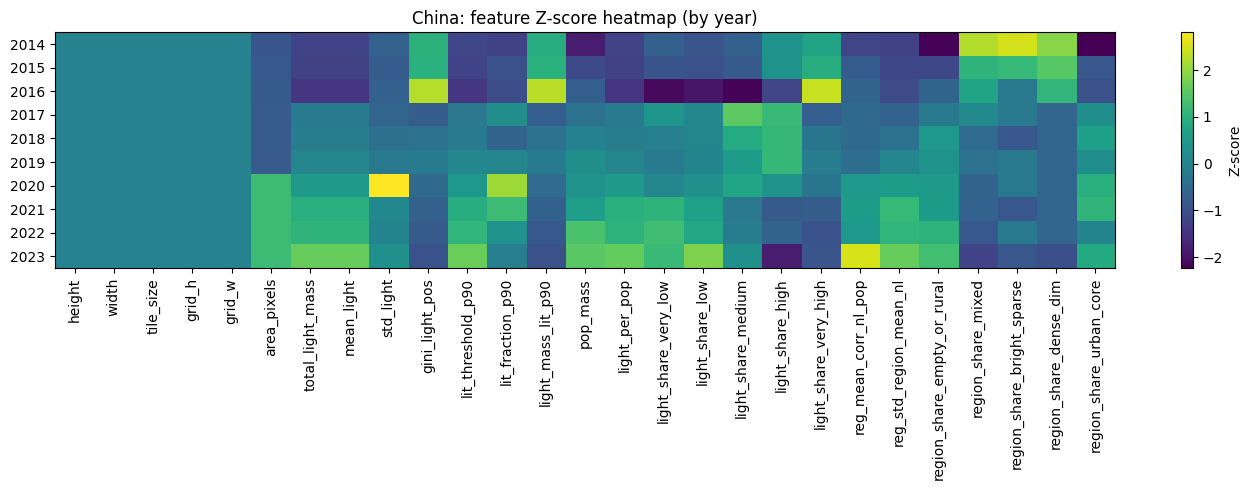

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_feature_zscore_heatmap.png


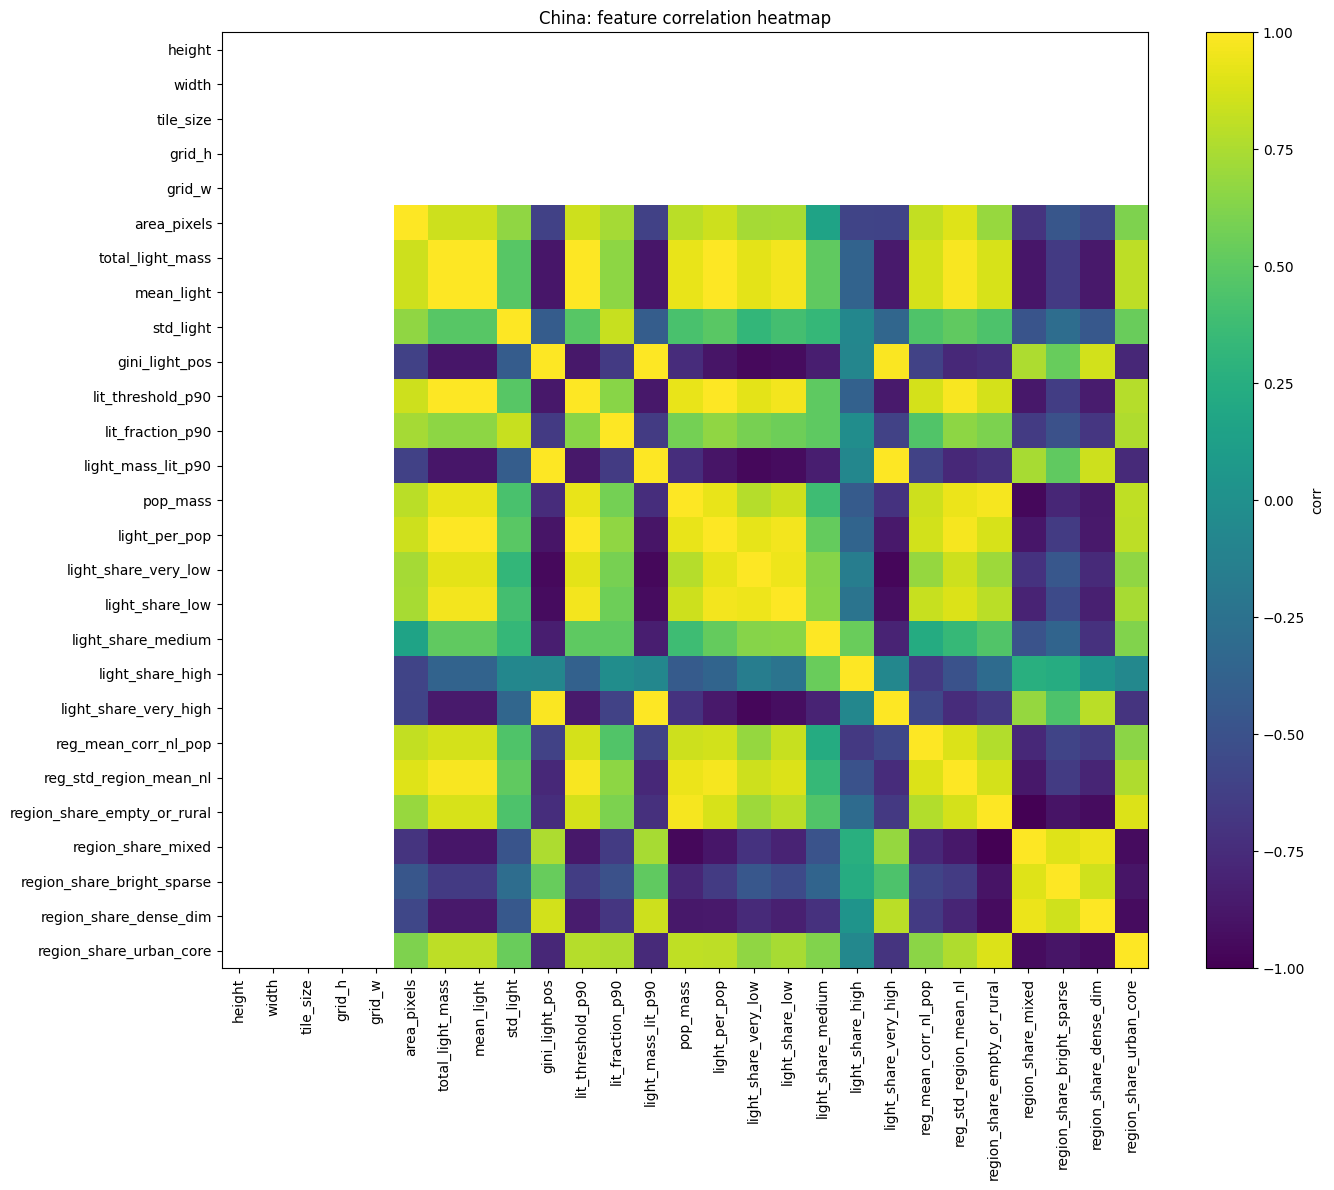

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_feature_corr_heatmap.png


In [6]:

# === Extra figure: Heatmaps of extracted features (easy to explain) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_path = os.path.join(OUTPUT_DIR, f"{COUNTRY}_features_country_year.csv")
df_hm = pd.read_csv(csv_path)

# Keep numeric columns only (drop non-numeric if any)
num = df_hm.select_dtypes(include=[np.number]).copy()
if "year" in num.columns:
    num = num.set_index("year")

# 1) Z-score heatmap (rows=years, cols=features)
X = num.values.astype(float)
mu = np.nanmean(X, axis=0, keepdims=True)
sd = np.nanstd(X, axis=0, keepdims=True)
sd = np.where(sd == 0, 1.0, sd)
Z = (X - mu) / sd

plt.figure(figsize=(min(14, 0.45*num.shape[1] + 4), 5))
plt.imshow(Z, aspect="auto")
plt.yticks(range(num.shape[0]), [str(i) for i in num.index])
plt.xticks(range(num.shape[1]), list(num.columns), rotation=90)
plt.title(f"{COUNTRY}: feature Z-score heatmap (by year)")
plt.colorbar(label="Z-score")
plt.tight_layout()
out1 = os.path.join(OUTPUT_DIR, f"{COUNTRY}_feature_zscore_heatmap.png")
plt.savefig(out1, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out1)

# 2) Correlation heatmap (feature-feature)
corr = num.corr(numeric_only=True).values
plt.figure(figsize=(min(14, 0.45*num.shape[1] + 4), min(12, 0.45*num.shape[1] + 3)))
plt.imshow(corr, vmin=-1, vmax=1, aspect="auto")
plt.xticks(range(num.shape[1]), list(num.columns), rotation=90)
plt.yticks(range(num.shape[1]), list(num.columns))
plt.title(f"{COUNTRY}: feature correlation heatmap")
plt.colorbar(label="corr")
plt.tight_layout()
out2 = os.path.join(OUTPUT_DIR, f"{COUNTRY}_feature_corr_heatmap.png")
plt.savefig(out2, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out2)


## Figures

C:\Users\BOUCHRA\AppData\Local\Temp\ipykernel_11240\1688381717.py:39: RuntimeWarning: Mean of empty slice
  nl_mean = np.nanmean(stack, axis=0)
C:\Users\BOUCHRA\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


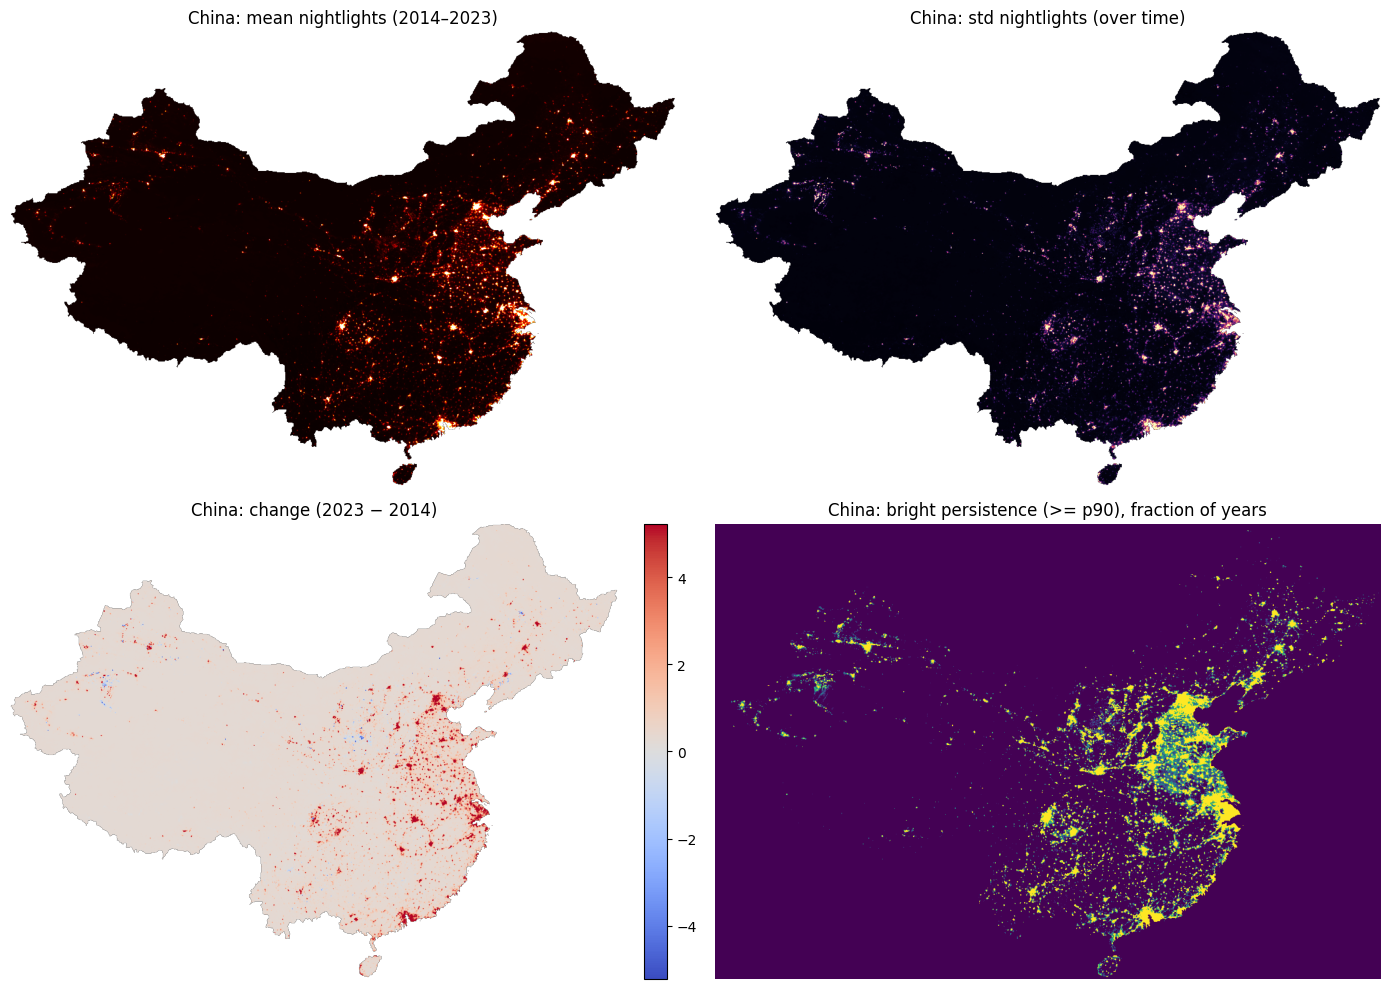

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_nightlights_summary_maps.png


In [7]:

# === Extra figure: Morocco-style nightlights summary maps (FAST for big rasters) ===
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

MAX_DIM = 1200  # reduce (800) if slow; increase (1500) if you want sharper
BAND_NL = 1

if not years_found:
    raise ValueError("No years found for this country. Check the file discovery cell above.")

y0, y1 = min(years_found), max(years_found)

# Map year -> file path
year_to_fp = {int(re.findall(r"_(\d{4})", os.path.basename(f))[0]): f for f in tifs}

def read_down(fp, band=1, max_dim=1200):
    with rasterio.open(fp) as src:
        h, w = src.height, src.width
        scale = max(h / max_dim, w / max_dim, 1.0)
        out_h, out_w = int(np.ceil(h / scale)), int(np.ceil(w / scale))
        a = src.read(band, out_shape=(out_h, out_w), resampling=Resampling.bilinear, masked=True).astype("float32")
        return np.ma.filled(a, np.nan)

def clip_img(a, p=99.5):
    v = a[np.isfinite(a)]
    if v.size == 0:
        return a
    hi = np.percentile(v, p)
    lo = np.nanmin(v)
    if not np.isfinite(hi) or hi <= lo:
        hi = lo + 1e-6
    return np.clip(a, lo, hi)

# Downsampled stack for mean/std + persistence
stack = np.stack([read_down(year_to_fp[y], BAND_NL, MAX_DIM) for y in years_found], axis=0)
nl_mean = np.nanmean(stack, axis=0)
nl_std  = np.nanstd(stack, axis=0)

nl0 = read_down(year_to_fp[y0], BAND_NL, MAX_DIM)
nl1 = read_down(year_to_fp[y1], BAND_NL, MAX_DIM)
nl_change = nl1 - nl0

v = stack[np.isfinite(stack)]
p90 = np.percentile(v, 90) if v.size else np.nan
nl_persist = np.nanmean(stack >= p90, axis=0) if np.isfinite(p90) else np.full_like(nl_mean, np.nan)

# Plot 2x2
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0,0].imshow(clip_img(nl_mean), cmap="hot", aspect="auto")
ax[0,0].set_title(f"{COUNTRY}: mean nightlights ({y0}–{y1})"); ax[0,0].axis("off")

ax[0,1].imshow(clip_img(nl_std), cmap="magma", aspect="auto")
ax[0,1].set_title(f"{COUNTRY}: std nightlights (over time)"); ax[0,1].axis("off")

chg = nl_change[np.isfinite(nl_change)]
lim = np.percentile(np.abs(chg), 99) if chg.size else 1.0
lim = lim if np.isfinite(lim) and lim > 0 else 1.0
im = ax[1,0].imshow(np.clip(nl_change, -lim, lim), cmap="coolwarm", aspect="auto")
ax[1,0].set_title(f"{COUNTRY}: change ({y1} − {y0})"); ax[1,0].axis("off")
plt.colorbar(im, ax=ax[1,0], fraction=0.046, pad=0.04)

ax[1,1].imshow(nl_persist, cmap="viridis", vmin=0, vmax=1, aspect="auto")
ax[1,1].set_title(f"{COUNTRY}: bright persistence (>= p90), fraction of years"); ax[1,1].axis("off")

plt.tight_layout()
out = os.path.join(OUTPUT_DIR, f"{COUNTRY}_nightlights_summary_maps.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out)


In [8]:
def savefig(name):
    fp = os.path.join(OUTPUT_DIR, name)
    plt.savefig(fp, dpi=150, bbox_inches="tight")
    print("Saved figure:", fp)
    plt.close()

# 1) Fast region typology maps (tile grid via imshow) for selected years
selected_years = [yy for yy in [2014, 2017, 2020, 2023] if yy in region_grids]
label_names = {
    0: "empty_or_rural",
    1: "mixed",
    2: "bright_sparse",
    3: "dense_dim",
    4: "urban_core",
}

for yy in selected_years:
    grid = region_grids[yy]
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, interpolation="nearest")
    plt.title(f"{COUNTRY} {yy} — region typology (tile grid)")
    plt.xlabel("tile column")
    plt.ylabel("tile row")
    cbar = plt.colorbar(ticks=list(label_names.keys()))
    cbar.ax.set_yticklabels([label_names[k] for k in label_names.keys()])
    savefig(f"China_region_typology_{yy}.png")

# 2) Sampled pixel scatter for latest year processed
if scatter_latest is not None and scatter_latest[0].size:
    x = scatter_latest[0]
    y = scatter_latest[1]
    plt.figure(figsize=(7, 6))
    plt.scatter(x, y, s=4, alpha=0.25)
    plt.xlabel("log(1 + population)")
    plt.ylabel("log(1 + nightlights)")
    plt.title(f"{COUNTRY} — sampled pixels (latest year)")
    savefig(f"China_scatter_latest_year.png")

# 3) Time-series of total_light_mass
if not features_df.empty:
    plt.figure(figsize=(7, 4))
    plt.plot(features_df["year"], features_df["total_light_mass"], marker="o")
    plt.xlabel("Year")
    plt.ylabel("Total light mass (sum of positive nightlights)")
    plt.title(f"{COUNTRY} — total_light_mass over time")
    savefig(f"China_total_light_mass_timeseries.png")


Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_region_typology_2014.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_region_typology_2017.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_region_typology_2020.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_region_typology_2023.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_scatter_latest_year.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\outputs\China_total_light_mass_timeseries.png


## Final feature table (for screenshot)

In [9]:
features_df

,country,year,height,width,tile_size,grid_h,grid_w,area_pixels,total_light_mass,mean_light,...,light_share_medium,light_share_high,light_share_very_high,reg_mean_corr_nl_pop,reg_std_region_mean_nl,region_share_empty_or_rural,region_share_mixed,region_share_bright_sparse,region_share_dense_dim,region_share_urban_core
0,China,2014,7882,13644,164,49,84,47053595,2.026164e+07,0.430607,...,0.057644,0.119203,0.621272,0.281409,1.116449,0.070516,0.734798,0.003066,0.003577,0.188043
1,China,2015,7882,13644,164,49,84,47053626,2.002675e+07,0.425615,...,0.056787,0.119373,0.631610,0.300673,1.137396,0.086868,0.713848,0.002044,0.003066,0.194175
2,China,2016,7882,13644,164,49,84,47053647,1.838576e+07,0.390621,...,0.046182,0.107928,0.706832,0.307748,1.160250,0.095043,0.707716,0.001022,0.002555,0.193664
3,China,2017,7882,13644,164,49,84,47053660,2.896398e+07,0.615552,...,0.074897,0.125369,0.547788,0.313945,1.273541,0.101175,0.698007,0.001022,0.000511,0.199285
4,China,2018,7882,13644,164,49,84,47053660,2.949664e+07,0.626872,...,0.069617,0.124985,0.571504,0.313808,1.351156,0.111395,0.686765,0.000511,0.000511,0.200818
5,China,2019,7882,13644,164,49,84,47053660,3.101173e+07,0.659072,...,0.067268,0.124982,0.579667,0.317625,1.458772,0.109862,0.689320,0.001022,0.000511,0.199285
6,China,2020,7882,13644,164,49,84,47055050,3.438866e+07,0.730818,...,0.068683,0.119257,0.571121,0.358505,1.577791,0.111906,0.684211,0.001022,0.000511,0.202351
7,China,2021,7882,13644,164,49,84,47055051,3.847657e+07,0.817693,...,0.061276,0.110759,0.547164,0.363218,1.733891,0.112417,0.683700,0.000511,0.000511,0.202862
8,China,2022,7882,13644,164,49,84,47055055,3.930534e+07,0.835305,...,0.062209,0.112078,0.535457,0.358936,1.717757,0.120082,0.680123,0.001022,0.000511,0.198263
9,China,2023,7882,13644,164,49,84,47055055,4.418386e+07,0.938982,...,0.065307,0.103246,0.538839,0.455814,1.859141,0.124170,0.673480,0.000511,0.000000,0.201840


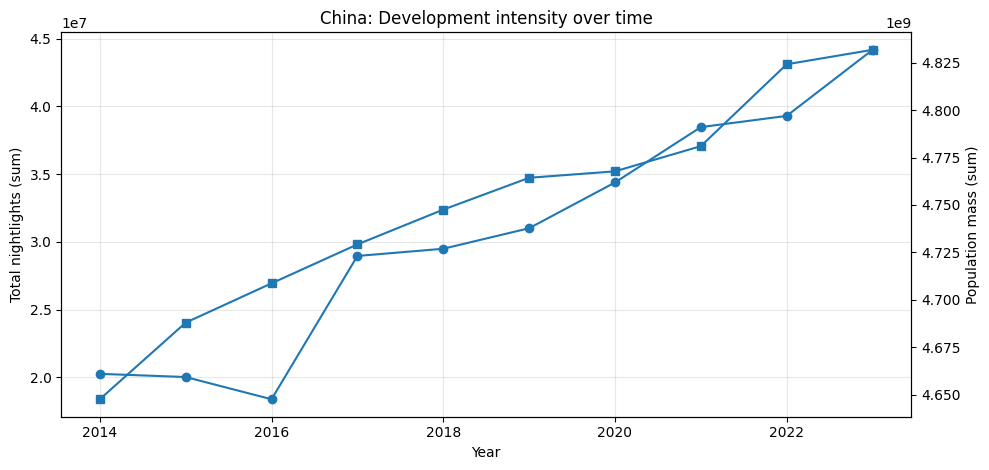

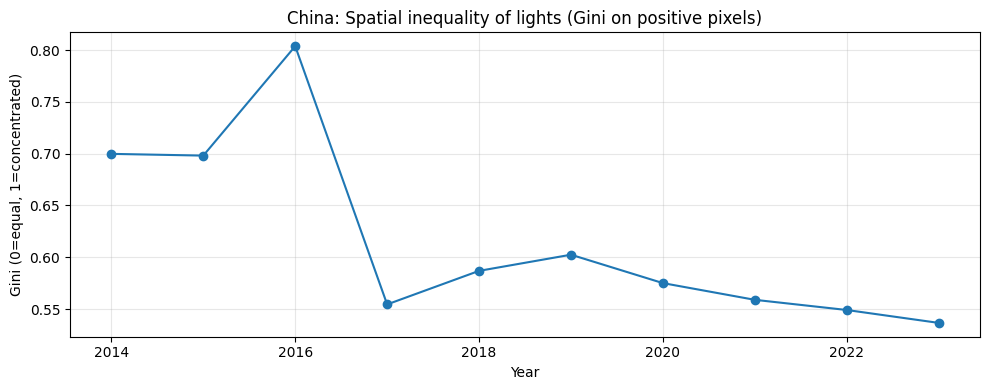

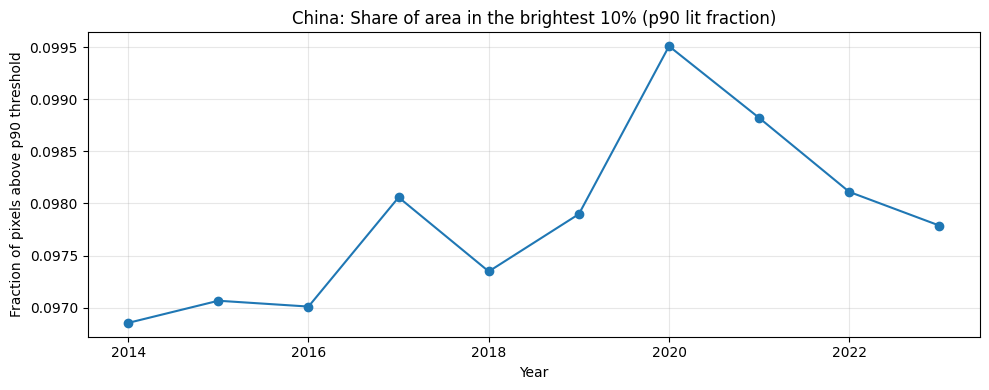

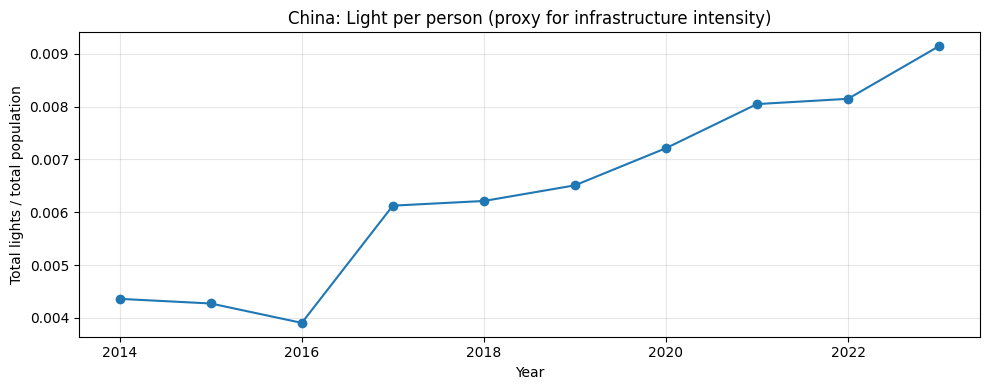

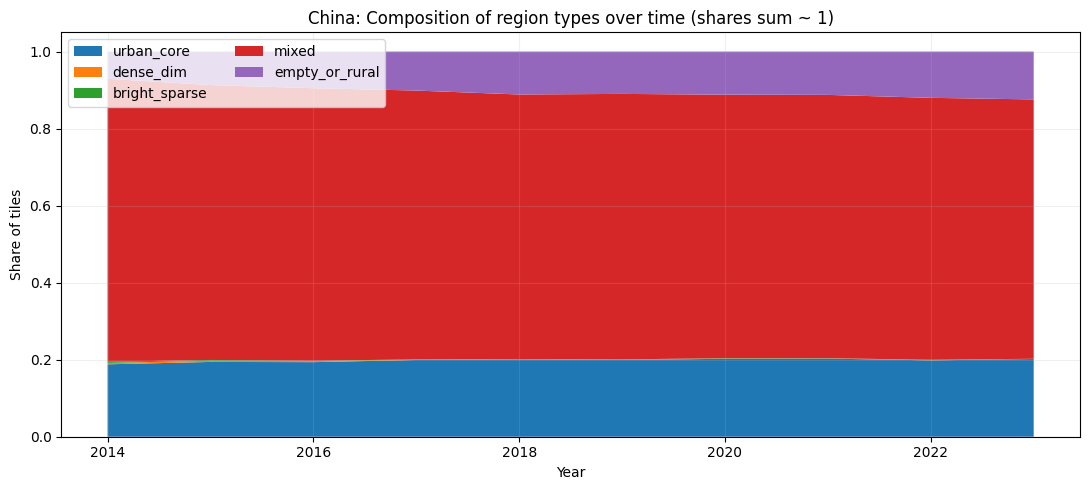

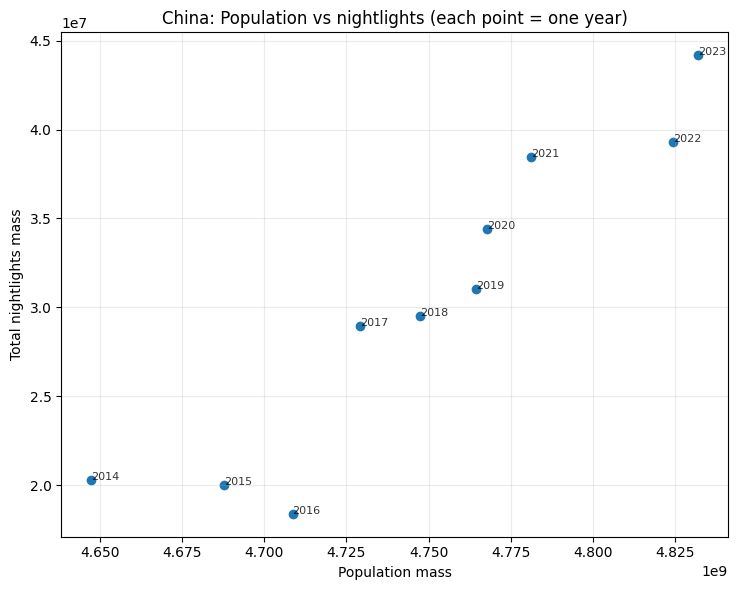


--- Plain-language summary ---
• Total lights changed by ~118.1% from 2014 to 2023.
• Light inequality (Gini) ranges from 0.537 to 0.804.
• Light per person ranges from 0.0039 to 0.00914.
• Latest year: urban_core share ≈ 20.2% of tiles.

Interpretation tip: rising total_light_mass suggests growth in lit infrastructure/activity;
rising Gini suggests increasing spatial concentration; region-share shifts show changes in urban vs rural structure.


In [10]:
# === Explain the extracted feature CSV (simple + visual + statistically meaningful) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- locate the feature table ---
# Prefer an in-memory DataFrame if you already have one (common names)
df = None
for name in ["country_year_df", "features_df", "df_features", "df_country_year", "df"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        # choose the one that looks like a country-year table
        if "year" in globals()[name].columns:
            df = globals()[name].copy()
            break

# Otherwise load from disk (outputs or week5_outputs/outputs)
if df is None:
    # Try common output dirs used in your notebooks
    out_dirs = []
    for v in ["OUTPUT_DIR", "OUTPUT_BASE"]:
        if v in globals() and isinstance(globals()[v], str):
            out_dirs.append(globals()[v])
    # fallbacks
    if "DATA_PATH" in globals():
        out_dirs += [os.path.join(DATA_PATH, "outputs"),
                     os.path.join(DATA_PATH, "week5_outputs"),
                     os.path.join(DATA_PATH, "week5_outputs", "outputs")]
    out_dirs += [os.getcwd(), os.path.join(os.getcwd(), "outputs")]

    # find csv
    csv_path = None
    for d in out_dirs:
        if not d or not os.path.isdir(d):
            continue
        candidate = os.path.join(d, f"{COUNTRY}_features_country_year.csv")
        if os.path.exists(candidate):
            csv_path = candidate
            break
    if csv_path is None:
        raise FileNotFoundError("Could not find the features CSV. Make sure you saved it first.")
    df = pd.read_csv(csv_path)
    print("Loaded:", csv_path)

# --- basic cleaning / ordering ---
df = df.copy()
df["year"] = df["year"].astype(int)
df = df.sort_values("year")

# helper: safe plot if column exists
def has(*cols):
    return all(c in df.columns for c in cols)

# ---------------------------
# 1) DEVELOPMENT OVER TIME: total light + population (dual axis)
# ---------------------------
if has("total_light_mass", "pop_mass"):
    fig, ax1 = plt.subplots(figsize=(10, 4.8))
    ax1.plot(df["year"], df["total_light_mass"], marker="o")
    ax1.set_title(f"{COUNTRY}: Development intensity over time")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Total nightlights (sum)")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(df["year"], df["pop_mass"], marker="s")
    ax2.set_ylabel("Population mass (sum)")
    plt.tight_layout()
    plt.show()

# ---------------------------
# 2) INEQUALITY / CONCENTRATION: Gini + top-10% concentration
# ---------------------------
if has("gini_light_pos"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df["year"], df["gini_light_pos"], marker="o")
    ax.set_title(f"{COUNTRY}: Spatial inequality of lights (Gini on positive pixels)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Gini (0=equal, 1=concentrated)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# If you have these tail metrics, show them
tail_cols = [c for c in ["lit_fraction_p90", "light_mass_lit_p90", "lit_threshold_p90"] if c in df.columns]
if "lit_fraction_p90" in df.columns:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df["year"], df["lit_fraction_p90"], marker="o")
    ax.set_title(f"{COUNTRY}: Share of area in the brightest 10% (p90 lit fraction)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Fraction of pixels above p90 threshold")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 3) LIGHT PER PERSON: interpretability metric
# ---------------------------
if has("light_per_pop"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df["year"], df["light_per_pop"], marker="o")
    ax.set_title(f"{COUNTRY}: Light per person (proxy for infrastructure intensity)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Total lights / total population")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 4) REGION MIX OVER TIME: stacked area of region shares (very explainable)
# ---------------------------
region_share_cols = [c for c in df.columns if c.startswith("region_share_")]
# pick a consistent order if present
order = [
    "region_share_urban_core",
    "region_share_dense_dim",
    "region_share_bright_sparse",
    "region_share_mixed",
    "region_share_empty_or_rural",
]
region_share_cols = [c for c in order if c in region_share_cols]

if len(region_share_cols) >= 3:
    fig, ax = plt.subplots(figsize=(11, 5))
    ys = [df[c].values for c in region_share_cols]
    ax.stackplot(df["year"], ys, labels=[c.replace("region_share_", "") for c in region_share_cols])
    ax.set_title(f"{COUNTRY}: Composition of region types over time (shares sum ~ 1)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Share of tiles")
    ax.legend(loc="upper left", ncol=2, frameon=True)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 5) ONE “STORY” SCATTER: population vs light with year labels
# ---------------------------
if has("pop_mass", "total_light_mass"):
    fig, ax = plt.subplots(figsize=(7.5, 6))
    ax.scatter(df["pop_mass"], df["total_light_mass"])
    for _, r in df.iterrows():
        ax.text(r["pop_mass"], r["total_light_mass"], str(int(r["year"])), fontsize=8, alpha=0.8)
    ax.set_title(f"{COUNTRY}: Population vs nightlights (each point = one year)")
    ax.set_xlabel("Population mass")
    ax.set_ylabel("Total nightlights mass")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 6) A short plain-language summary (prints)
# ---------------------------
print("\n--- Plain-language summary ---")
if has("total_light_mass"):
    growth = (df["total_light_mass"].iloc[-1] / df["total_light_mass"].iloc[0] - 1) * 100 if df["total_light_mass"].iloc[0] != 0 else np.nan
    print(f"• Total lights changed by ~{growth:.1f}% from {df['year'].iloc[0]} to {df['year'].iloc[-1]}.")
if has("gini_light_pos"):
    print(f"• Light inequality (Gini) ranges from {df['gini_light_pos'].min():.3f} to {df['gini_light_pos'].max():.3f}.")
if has("light_per_pop"):
    print(f"• Light per person ranges from {df['light_per_pop'].min():.3g} to {df['light_per_pop'].max():.3g}.")
if len(region_share_cols) > 0:
    last = df.iloc[-1]
    key = "region_share_urban_core"
    if key in df.columns:
        print(f"• Latest year: urban_core share ≈ {last[key]*100:.1f}% of tiles.")
print("\nInterpretation tip: rising total_light_mass suggests growth in lit infrastructure/activity;")
print("rising Gini suggests increasing spatial concentration; region-share shifts show changes in urban vs rural structure.")